# Truncated Skewed Levy Distribution

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import pandas as pd
from arch import arch_model

## Training data

In [3]:
dfs = pd.read_excel('../Indices_Data.xlsx', sheet_name=None)

euronext100 = dfs['Euronext100'][['Date', 'Close']]
stoxx50e = dfs['Stoxx50E'][['Date', 'Close']]
snp500 = dfs['S&P500'][['Date', 'Close']]

data = snp500.copy()
data = data[(data['Date'] > '2006-01-01') & (data['Date'] < '2017-12-31')].reset_index()

data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))*100
data['10 Days Returns'] = data['Returns'].rolling(window=10).sum()
data['210 Days Returns'] = data['Returns'].rolling(window=210).sum()
data = data.iloc[251:].reset_index()

## Fit the Garch
The Garch model:

In [4]:
def model(returns : pd.DataFrame, omega, alpha, gamma, beta, kappa):
    t_max = len(returns)
    epsilon = np.zeros(t_max)
    sigma = np.zeros(t_max+1)

    sigma[0]= returns.std()
    
    for t in range(t_max):
        if returns[t]<0:
            leverage=1
        else:
            leverage=0
        epsilon[t] = returns[t]/sigma[t]
        sigma[t+1] = np.power(omega + alpha*np.power(np.abs(epsilon[t]),kappa)+gamma*leverage*np.power(np.abs(epsilon[t]),kappa)+beta*np.power(sigma[t],kappa), 1/kappa)
    return sigma

In [38]:
garch = arch_model(data['Returns'], p=1, q=1, o=1, power=1.76, dist='normal')
results=garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 45073776.72837777
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3206652419.0222716
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3795.577197006219
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3688.451477282945
Iteration:      5,   Func. Count:     39,   Neg. LLF: 9431.269747781098
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3685.918016514541
Iteration:      7,   Func. Count:     54,   Neg. LLF: 3683.1272848367907
Iteration:      8,   Func. Count:     60,   Neg. LLF: 3683.12225352771
Iteration:      9,   Func. Count:     67,   Neg. LLF: 3683.1044010797277
Iteration:     10,   Func. Count:     73,   Neg. LLF: 3683.1037852779145
Iteration:     11,   Func. Count:     78,   Neg. LLF: 3683.103785280225
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3683.1037852779145
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Asym. Power GARCH (power: 1.8) Model Results               
==========================================================================================
Dep. Variable:                            Returns   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:         Asym. Power GARCH (power: 1.8)   Log-Likelihood:               -3683.10
Distribution:                              Normal   AIC:                           7376.21
Method:                        Maximum Likelihood   BIC:                           7405.84
                                                    No. Observations:                 2769
Date:                            Thu, Apr 10 2025   Df Residuals:                     2768
Time:                                    19:38:10   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0263  1.466e-02      1.792  7.309e-02 [-2.458e-03,5.501e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0247  5.356e-03      4.605  4.124e-06  [1.417e-02,3.516e-02]
alpha[1]       0.0000  2.057e-02      0.000      1.000 [-4.032e-02,4.032e-02]
gamma[1]       0.2059  3.003e-02      6.858  7.000e-12      [  0.147,  0.265]
beta[1]        0.8818  1.835e-02     48.043      0.000      [  0.846,  0.918]
=============================================================================

Covariance estimator: robust
"""

In [7]:
latex = results.summary().as_latex()
with open('table.tex', 'w') as f:
    f.write(latex)

In [8]:
print(results.params)

mu          0.026274
omega       0.024663
alpha[1]    0.000000
gamma[1]    0.205948
beta[1]     0.881810
Name: params, dtype: float64


In [9]:
mean = results.params['mu']
std_dev = model(data['Returns'],omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)

In [10]:
data['Standardized Returns'] = (data['Returns']-mean)/std_dev[:-1]
data['Volatilities'] = std_dev[:-1]

In [11]:
kde= gaussian_kde(data['Standardized Returns'])
x_values = np.linspace(-8,8,1000)
y_kde=kde(x_values)

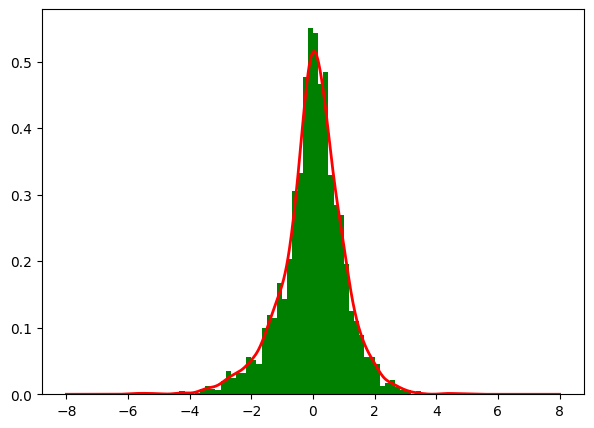

In [12]:
plt.figure(figsize=(7, 5))
plt.hist(data['Standardized Returns'], range=(-5, 5), bins=60, density=True, color='green')
plt.plot(x_values,y_kde, color='red', linewidth = 2)
plt.show()

## Empirical quantiles

In [13]:
percentile_1 = np.percentile(data['Standardized Returns'], 1)
percentile_5 = np.percentile(data['Standardized Returns'], 5)
percentile_10 = np.percentile(data['Standardized Returns'], 10)

print(f"1st percentile: {percentile_1:.4f}")
print(f"5th percentile: {percentile_5:.4f}")
print(f"10th percentile: {percentile_10:.4f}")

1st percentile: -2.9617
5th percentile: -1.8499
10th percentile: -1.2832


In [21]:
data['1 Day VaR'] = data['Volatilities'] * percentile_10

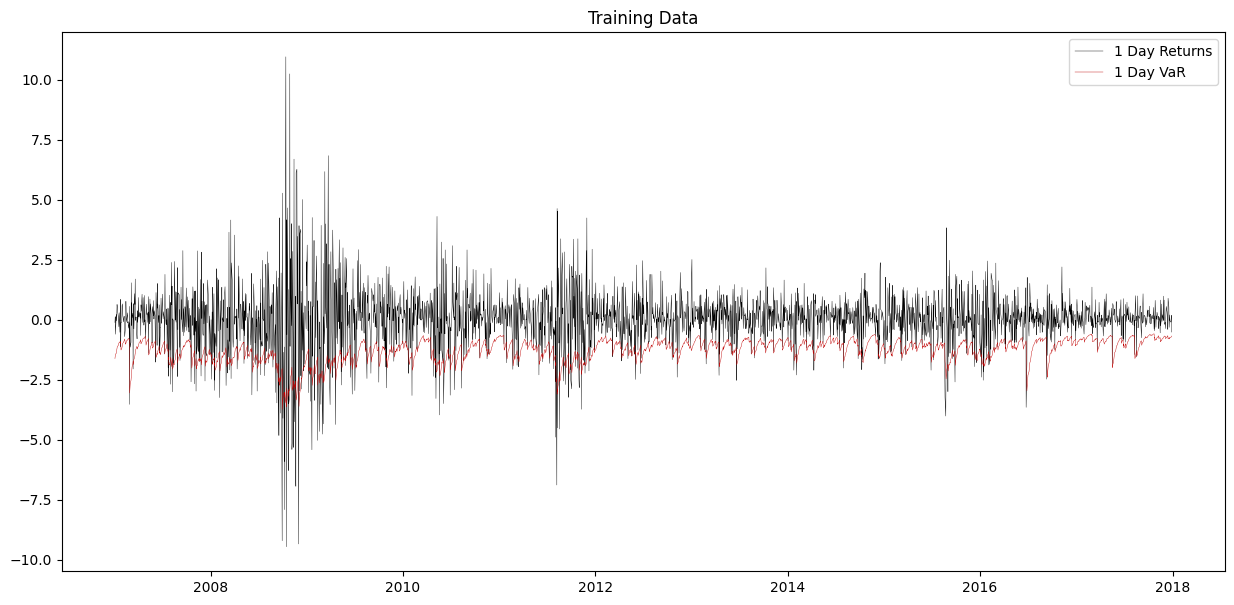

In [22]:
plt.figure(figsize=(15,7))
plt.plot(data['Date'],data['Returns'],label='1 Day Returns', color='black',linewidth = 0.3)
plt.plot(data['Date'],data['1 Day VaR'],label='1 Day VaR', color = '#C00000', linewidth = 0.3)
plt.title('Training Data')
plt.legend()
plt.show()

In [23]:
data['Violations']=data['1 Day VaR'] > data['Returns']
violations = data['Violations'].mean() * 100
print(violations, '%')

9.606356085229324 %


In [24]:
test_data = snp500.copy()
test_data = test_data[(test_data['Date'] > '2017-12-21') & (test_data['Date'] < '2024-12-31')].reset_index()
test_data['Returns'] = np.log(test_data['Close'] / test_data['Close'].shift(1)) * 100
test_data['10 Days Returns'] = test_data['Returns'].rolling(window=10).sum()
test_data = test_data.dropna().reset_index()
test_data[['Date', 'Returns', '10 Days Returns']]

,Date,Returns,10 Days Returns
0,2018-01-09,0.130208,2.500759
1,2018-01-10,-0.111285,2.495372
2,2018-01-11,0.700903,3.117211
3,2018-01-12,0.672693,3.606672
4,2018-01-16,-0.353071,3.773264
...,...,...,...
1750,2024-12-23,0.726085,-1.310084
1751,2024-12-24,1.098223,0.084967
1752,2024-12-26,-0.040574,-0.768869
1753,2024-12-27,-1.111730,-1.337727


In [25]:
mean = results.params['mu']
test_std_dev = model(test_data['Returns'], omega=results.params['omega'], alpha=results.params['alpha[1]'],
                     gamma=results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)
test_std_dev

array([1.24877628, 1.17509262, 1.10878315, ..., 1.3508274 , 1.33729651,
       1.3226579 ])

In [29]:
test_data['Standardized Returns'] = (test_data['Returns'] - mean) / test_std_dev[:-1]
test_data['Volatilities'] = test_std_dev[:-1]
test_data['1 Day VaR'] = percentile_10 * test_data['Volatilities']
test_data['Violations'] = test_data['1 Day VaR'] > test_data['Returns']
test_violations = test_data['Violations'].mean() * 100
test_data
print(test_violations)


9.45868945868946


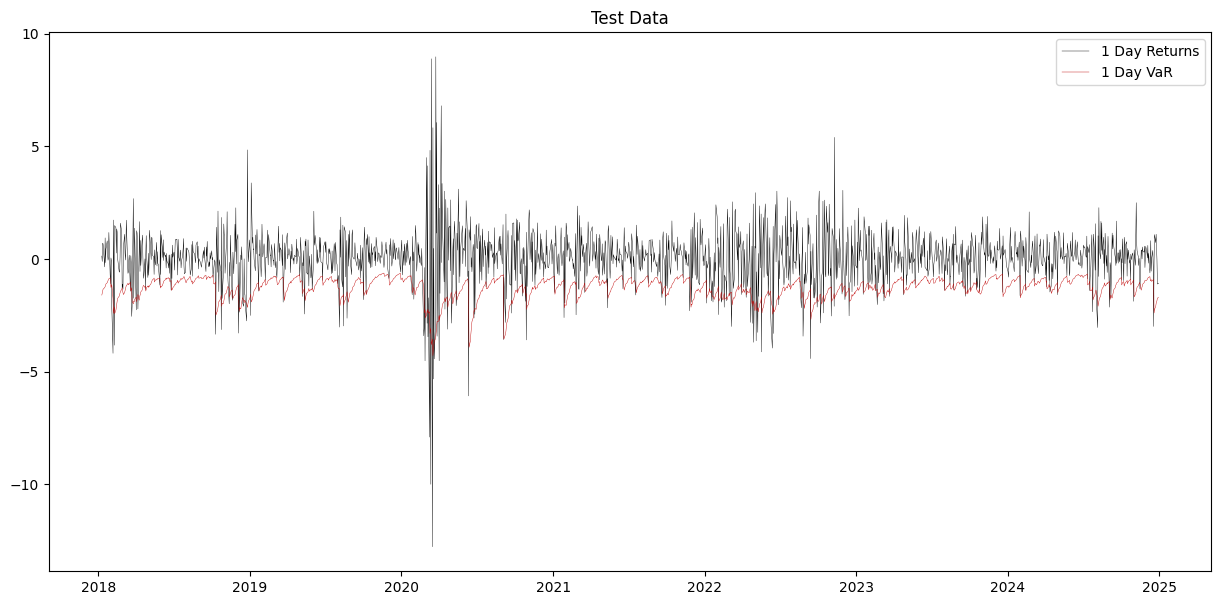

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(test_data['Date'], test_data['Returns'], label='1 Day Returns', color='black', linewidth=0.3)
plt.plot(test_data['Date'], test_data['1 Day VaR'], label='1 Day VaR', color='#C00000', linewidth=0.3)
plt.title('Test Data')
plt.legend()
plt.show()

## 10 Days Garch fit

In [69]:
ten_days_training = test_data[['10 Days Returns']][::10].copy().reset_index(drop=True).to_numpy().flatten()

In [70]:
print(ten_days_training)

[ 2.50075868e+00  3.08675866e+00 -5.65015204e+00  8.28137774e-01
  1.28645759e+00 -3.54062803e+00 -1.49464580e+00  2.49016769e+00
 -2.51988334e-01  1.84329830e+00  1.24181594e+00  9.73807096e-01
 -1.71044553e+00  2.99286056e+00  2.39608427e-01  8.36952399e-01
  2.00652516e+00 -2.97250264e-01  5.88452873e-01 -4.22752473e+00
 -4.76330659e+00  5.77089112e+00 -6.00346307e+00 -6.37890544e-01
 -8.57843752e+00  6.32504293e+00  2.46660056e+00  3.46048652e+00
  1.57162425e+00 -9.39574060e-01  3.78180495e+00  8.54865920e-01
  8.86529851e-01  1.38823472e+00 -2.96687886e+00 -4.10766131e+00
  5.15616089e+00  2.55087819e+00  1.33069988e+00  3.03791440e-01
 -2.92502925e+00 -1.97264109e+00  4.49029445e+00 -5.36598378e-01
 -2.21781518e+00  2.87397457e+00  2.37657771e+00  1.02438090e+00
  2.88150837e-01  2.78186424e+00  1.26821695e+00  2.26929838e+00
 -7.01079290e-01  2.65016287e+00 -7.86221740e+00 -2.66394582e+01
  2.97437614e+00  1.25038148e+01  3.95290534e+00 -2.07919580e+00
  6.50784910e+00 -9.85930

In [57]:
ten_days_garch = arch_model(ten_days_training, p=1, q=1, o=1, power=1.76, dist='normal')
ten_days_results=ten_days_garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1080.0484798249242
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1753.0168528322133
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1895.4463819123905
Iteration:      4,   Func. Count:     34,   Neg. LLF: 752.3527621917797
Iteration:      5,   Func. Count:     42,   Neg. LLF: 682.6663365527811
Iteration:      6,   Func. Count:     49,   Neg. LLF: 680.9881173468742
Iteration:      7,   Func. Count:     55,   Neg. LLF: 680.911495148626
Iteration:      8,   Func. Count:     61,   Neg. LLF: 680.8877962877123
Iteration:      9,   Func. Count:     67,   Neg. LLF: 680.8825557491664
Iteration:     10,   Func. Count:     73,   Neg. LLF: 680.8824740664259
Iteration:     11,   Func. Count:     79,   Neg. LLF: 680.8824707803499
Iteration:     12,   Func. Count:     84,   Neg. LLF: 680.8824707803872
Optimization terminated successfully    (Exit mode 0)
            Current function value: 680.8824707803499
            Iterations: 12

In [58]:
ten_days_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Asym. Power GARCH (power: 1.8) Model Results               
==========================================================================================
Dep. Variable:                                  y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:         Asym. Power GARCH (power: 1.8)   Log-Likelihood:               -680.882
Distribution:                              Normal   AIC:                           1371.76
Method:                        Maximum Likelihood   BIC:                           1389.89
                                                    No. Observations:                  277
Date:                            Thu, Apr 10 2025   Df Residuals:                      276
Time:                                    19:45:52   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.2628      0.148      1.777  7.555e-02 [-2.704e-02,  0.553]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.4871      0.255      1.913  5.581e-02 [-1.208e-02,  0.986]
alpha[1]       0.0000  9.654e-02      0.000      1.000    [ -0.189,  0.189]
gamma[1]       0.4465      0.227      1.970  4.880e-02  [2.350e-03,  0.891]
beta[1]        0.7498  7.367e-02     10.178  2.485e-24    [  0.605,  0.894]
===========================================================================

Covariance estimator: robust
"""

In [71]:
ten_days_volatilities = model(ten_days_training,omega=ten_days_results.params['omega'],alpha=ten_days_results.params['alpha[1]'],gamma = ten_days_results.params['gamma[1]'],beta=ten_days_results.params['beta[1]'],kappa=1.76)

std_ten_days_training = (ten_days_training - ten_days_results.params['mu'])/ten_days_volatilities[:-1]

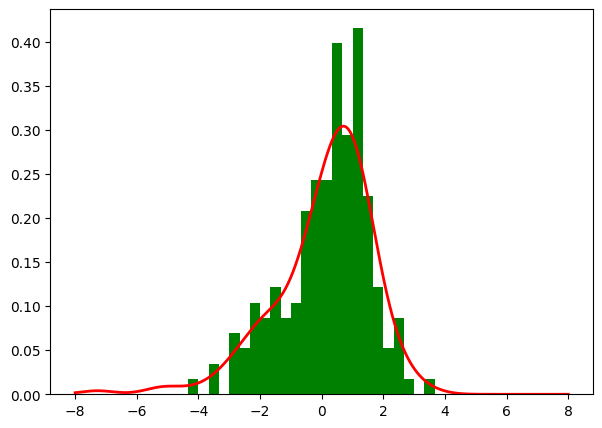

In [72]:
kde = gaussian_kde(std_ten_days_training)
x_values = np.linspace(-8, 8, 1000)
y_kde = kde(x_values)
plt.figure(figsize=(7, 5))
plt.hist(std_ten_days_training, range=(-5, 5), bins=30, density=True, color='green')
plt.plot(x_values, y_kde, color='red', linewidth=2)
plt.show()

In [73]:
percentile_1 = np.percentile(std_ten_days_training, 1)
percentile_5 = np.percentile(std_ten_days_training, 5)
percentile_10 = np.percentile(std_ten_days_training, 10)


print(f"1st percentile: {percentile_1:.4f}")
print(f"5th percentile: {percentile_5:.4f}")
print(f"10th percentile: {percentile_10:.4f}")

1st percentile: -5.0844
5th percentile: -2.7908
10th percentile: -2.0668


In [85]:
# get the CDF values

x_array = np.linspace(-10,10,1000)
cdf_values = np.array([kde.integrate_box(-np.inf, x, 10000) for x in x_array])

quantile = 0.10
# find the index of the closest CDF value to the desired quantile
idx = np.argmin(np.abs(cdf_values - quantile))

# interpolate to find the quantile value
quantile_value = np.interp(quantile, cdf_values, np.linspace(kde.dataset.min(), kde.dataset.max(), 1000))
print(quantile_value)

-3.063064196586232


In [86]:
percentile_1 = -4.78304045138368
percentile_5 = -3.496539280753607
percentile_10 = -3.063064196586232

In [92]:
from scipy.stats import norm
# Output: ~1.64485

In [98]:
percentile_1 = norm.ppf(0.1)
print(percentile_1)

-1.2815515655446004


In [99]:
ten_days_training_var = ten_days_volatilities[:-1] * percentile_1
ten_days_training_breaches = ten_days_training_var > ten_days_training
ten_days_training_tot_breach = ten_days_training_breaches.mean() * 100
print(ten_days_training_tot_breach)

16.477272727272727
